In [78]:
import time
import scipy
import numpy as np
import pandas as pd
import winsound

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn.functional as F

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.nn import HGTConv, SAGEConv, GATConv, Linear, to_hetero, models

from HeteroDataFunctions import Encoder, add_types, complete_graph, flatten_lol, node_cat_dict, midi_type, plot_graph, plot_4graphs

# print(scipy.__version__)
# print(matplotlib.__version__)
# print(nx.__version__)
print(torch.__version__)

2.0.0+cu118


In [79]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 960
Memory Usage:
Allocated: 0.1 GB
Cached:    0.4 GB


In [80]:
# Complete Dataset
G = complete_graph(".\slac\embeddings\\all")

loading edgelists...
- notes.edgelist
- program.edgelist
- tempo.edgelist
- time.signature.edgelist
Nodes: 93553
Edges: 786635


In [81]:
nodes = pd.DataFrame((list(G.nodes)), columns=['name'])
edges = pd.DataFrame(np.array(list(G.edges)), columns=['source', 'target'])

In [82]:
node_categories = node_cat_dict(nodes)
node_categories.keys()

node_cat_dict took 0.19 secs to run


dict_keys(['note_group', 'pitch', 'program', 'MIDI', 'duration', 'velocity', 'time_sig', 'tempo'])

In [83]:
%%script false --no- raise -error

nodes_df_complete, edges_df_complete = add_types(nodes, edges, node_categories)

winsound.Beep(400, 700)

nodes_df_complete.to_csv('nodes_complete.csv')
edges_df_complete.to_csv('edges_complete.csv')

Couldn't find program: 'false'


In [84]:
nodes_df_complete = pd.read_csv('.\slac\Contents of Slac\\nodes_complete.csv')
edges_df_complete = pd.read_csv('.\slac\Contents of Slac\edges_complete.csv')
print('Done')

Done


In [85]:
node_types = set(nodes_df_complete['node_type'])
node_types


{'MIDI',
 'duration',
 'note_group',
 'pitch',
 'program',
 'tempo',
 'time_sig',
 'velocity'}

In [86]:
edge_types = ["MIDI__has__tempo",
                   "MIDI__in__time_sig",
                   "MIDI__has__program",
                   "MIDI__has__note_group",
                   "note_group__has__velocity",
                   "note_group__has__duration",
                   "note_group__contains__pitch"]

In [87]:
names_list = flatten_lol(node_categories.values())


In [88]:
encoder = Encoder(names_list, n_labels=10)


In [89]:
input_node_dict = {node_type: {'x': encoder.
                    encode_nodes(nodes_df_complete.
                    loc[nodes_df_complete['node_type'] == node_type, ['name']])}
                    for node_type in node_types}

encode_nodes took 0.00 secs to run
encode_nodes took 0.01 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 3.42 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.02 secs to run
encode_nodes took 0.00 secs to run


In [90]:
node_enc_to_idx = {node_type: {encoder.decode_value(node_enc.item()): i for i, node_enc in enumerate(input_node_dict[node_type]['x'])} for node_type in node_types}

In [91]:
input_edge_dict = dict()
for edge_type in edge_types:
    node_type_s, node_type_t = edge_type.split('__')[0], edge_type.split('__')[2]

    edge_df = edges_df_complete.loc[edges_df_complete['edge_type'] == edge_type, ['source', 'target']].copy()

    edge_df['source'], edge_df['target'] = edge_df['source'].map(node_enc_to_idx[node_type_s]), edge_df['target'].map(node_enc_to_idx[node_type_t])

    input_edge_dict[edge_type] = {'edge_index': torch.tensor(edge_df.values).T}


In [92]:
# Extract the label of each Midi.
midi_val = nodes_df_complete.loc[nodes_df_complete['node_type'] == 'MIDI', ['name']].values
midi_class_5 = [midi_type(s[0], 5) for s in midi_val]

lb = LabelEncoder()
y_5 = torch.from_numpy(lb.fit_transform(midi_class_5)) # .type(torch.LongTensor)

lb.classes_

array(['Blues', 'Classical', 'Jazz', 'Rap', 'Rock'], dtype='<U9')

In [93]:
input_node_dict_5 = input_node_dict.copy()

input_node_dict_5['MIDI']['y'] = y_5

In [94]:
H_5 = HeteroData(input_node_dict_5, **input_edge_dict).to(device)

In [95]:
print(H_5)

HeteroData(
  pitch={ x=[93, 1] },
  MIDI={
    x=[250, 1],
    y=[250]
  },
  tempo={ x=[23, 1] },
  time_sig={ x=[14, 1] },
  note_group={ x=[92484, 1] },
  velocity={ x=[11, 1] },
  duration={ x=[570, 1] },
  program={ x=[108, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] }
)


In [96]:
H_5 = T.ToUndirected()(H_5)

In [97]:
H_5 = T.RandomNodeSplit(num_val=0.1, num_test=0.1)(H_5)

In [98]:
print(H_5)

HeteroData(
  pitch={ x=[93, 1] },
  MIDI={
    x=[250, 1],
    y=[250],
    train_mask=[250],
    val_mask=[250],
    test_mask=[250]
  },
  tempo={ x=[23, 1] },
  time_sig={ x=[14, 1] },
  note_group={ x=[92484, 1] },
  velocity={ x=[11, 1] },
  duration={ x=[570, 1] },
  program={ x=[108, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] },
  (tempo, rev_has, MIDI)={ edge_index=[2, 250] },
  (time_sig, rev_in, MIDI)={ edge_index=[2, 239] },
  (program, rev_has, MIDI)={ edge_index=[2, 1392] },
  (note_group, rev_has, MIDI)={ edge_index=[2, 135160] },
  (velocity, rev_has, note_group)={ edge_index=[2, 118626] },
  (duration, rev_has, note_group)={ edge_index=[2, 924

In [99]:
H_5['MIDI'].test_mask

tensor([False, False, False, False, False, False, False, False, False, False,
         True, False,  True, False, False, False, False, False, False, False,
         True, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False,  True, False, False,
        False, False, False, False,  True, False, False, False, 

# GNN

In [100]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, drop_layer: bool=False, drop_rate: float=0.5):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)
        self.drop = drop_layer
        self.drop_rate = drop_rate

    def forward(self, x, edge_index):
        if self.drop:
            x = F.dropout(x, p=self.drop_rate, training=self.training)
            x = self.conv1(x, edge_index).relu()
            x = F.dropout(x, p=self.drop_rate, training=self.training)
            x = self.conv2(x, edge_index)
        else:
            x = self.conv1(x, edge_index).relu()
            x = self.conv2(x, edge_index)
        return x

In [101]:
model_5 = models.GraphSAGE(in_channels=-1, hidden_channels=64, num_layers=2, out_channels=len(set(lb.classes_)))
model_5 = to_hetero(model_5, H_5.metadata(), aggr='sum')
model_5.to(device)
# model_5 = torch_geometric.compile(model_5)

GraphModule(
  (_trim): ModuleDict(
    (MIDI__has__tempo): TrimToLayer()
    (MIDI__in__time_sig): TrimToLayer()
    (MIDI__has__program): TrimToLayer()
    (MIDI__has__note_group): TrimToLayer()
    (note_group__has__velocity): TrimToLayer()
    (note_group__has__duration): TrimToLayer()
    (note_group__contains__pitch): TrimToLayer()
    (tempo__rev_has__MIDI): TrimToLayer()
    (time_sig__rev_in__MIDI): TrimToLayer()
    (program__rev_has__MIDI): TrimToLayer()
    (note_group__rev_has__MIDI): TrimToLayer()
    (velocity__rev_has__note_group): TrimToLayer()
    (duration__rev_has__note_group): TrimToLayer()
    (pitch__rev_contains__note_group): TrimToLayer()
  )
  (convs): ModuleList(
    (0): ModuleDict(
      (MIDI__has__tempo): SAGEConv(-1, 64, aggr=mean)
      (MIDI__in__time_sig): SAGEConv(-1, 64, aggr=mean)
      (MIDI__has__program): SAGEConv(-1, 64, aggr=mean)
      (MIDI__has__note_group): SAGEConv(-1, 64, aggr=mean)
      (note_group__has__velocity): SAGEConv(-1, 64, agg

In [102]:
optimizer_name = "Adam"
optimizer = torch.optim.Adam(model_5.parameters(), lr=0.01)


In [103]:
def train5():
    model_5.train()
    optimizer.zero_grad()
    out = model_5(H_5.x_dict, H_5.edge_index_dict)
    mask = H_5['MIDI'].train_mask
    loss = F.cross_entropy(out['MIDI'][mask], H_5['MIDI'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)

In [104]:
@torch.no_grad()
def test5():
    model_5.eval()
    pred = model_5(H_5.x_dict, H_5.edge_index_dict)['MIDI'].argmax(dim=-1)

    accs = []

    for mask in [H_5['MIDI'].train_mask, H_5['MIDI'].val_mask, H_5['MIDI'].test_mask]:
        accs.append(int((pred[mask] == H_5['MIDI'].y[mask]).sum()) / int(mask.sum()))
    return accs

In [105]:
acc_lists = {'train': [], 'val': [], 'test': []}
loss_list = []

for epoch in range(1, 801):
    loss = train5()
    train_acc, val_acc, test_acc = test5()

    loss_list.append(loss)

    acc_lists['train'].append(train_acc)
    acc_lists['val'].append(val_acc)
    acc_lists['test'].append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 171763.8125, Train: 0.2050, Val: 0.2000, Test: 0.1600
Epoch: 002, Loss: 147628.5156, Train: 0.2150, Val: 0.1200, Test: 0.1600
Epoch: 003, Loss: 286379.1250, Train: 0.2000, Val: 0.1600, Test: 0.2400
Epoch: 004, Loss: 373754.1875, Train: 0.2000, Val: 0.2000, Test: 0.2000
Epoch: 005, Loss: 428762.4062, Train: 0.2000, Val: 0.2000, Test: 0.2000
Epoch: 006, Loss: 387396.5938, Train: 0.0050, Val: 0.0800, Test: 0.0000
Epoch: 007, Loss: 270315.4688, Train: 0.2750, Val: 0.2400, Test: 0.2400
Epoch: 008, Loss: 259975.1250, Train: 0.2150, Val: 0.1200, Test: 0.1600
Epoch: 009, Loss: 251562.5938, Train: 0.2450, Val: 0.2000, Test: 0.1600
Epoch: 010, Loss: 209806.0938, Train: 0.2750, Val: 0.2800, Test: 0.2000
Epoch: 011, Loss: 146342.0156, Train: 0.3900, Val: 0.3200, Test: 0.3200
Epoch: 012, Loss: 99447.8438, Train: 0.2050, Val: 0.2000, Test: 0.1600
Epoch: 013, Loss: 114372.7188, Train: 0.2050, Val: 0.2000, Test: 0.1600
Epoch: 014, Loss: 67060.0625, Train: 0.2050, Val: 0.3600, Test: 0

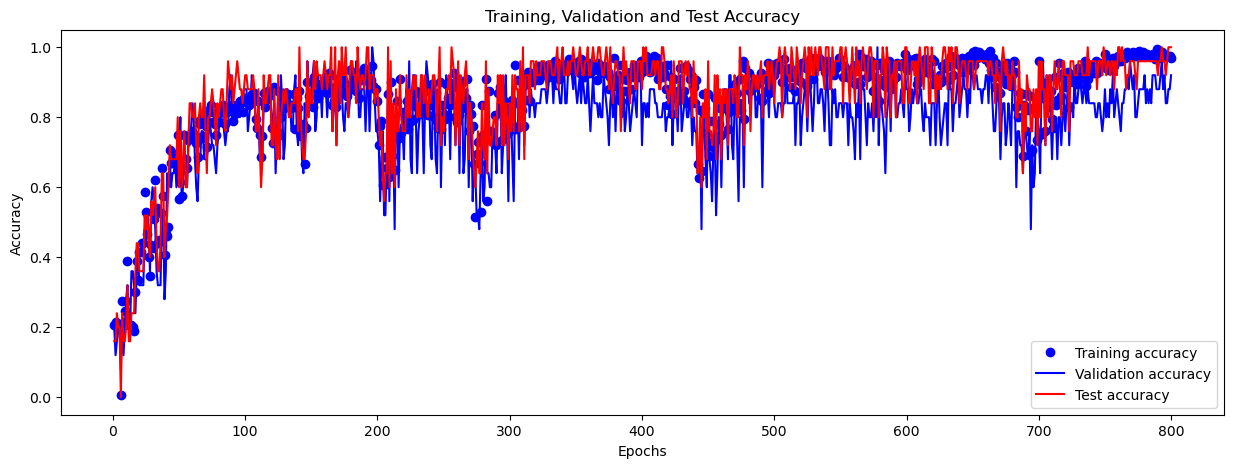

In [106]:
plot_graph(acc_lists, ".\slac\\figures\slac_5_tvt.png")


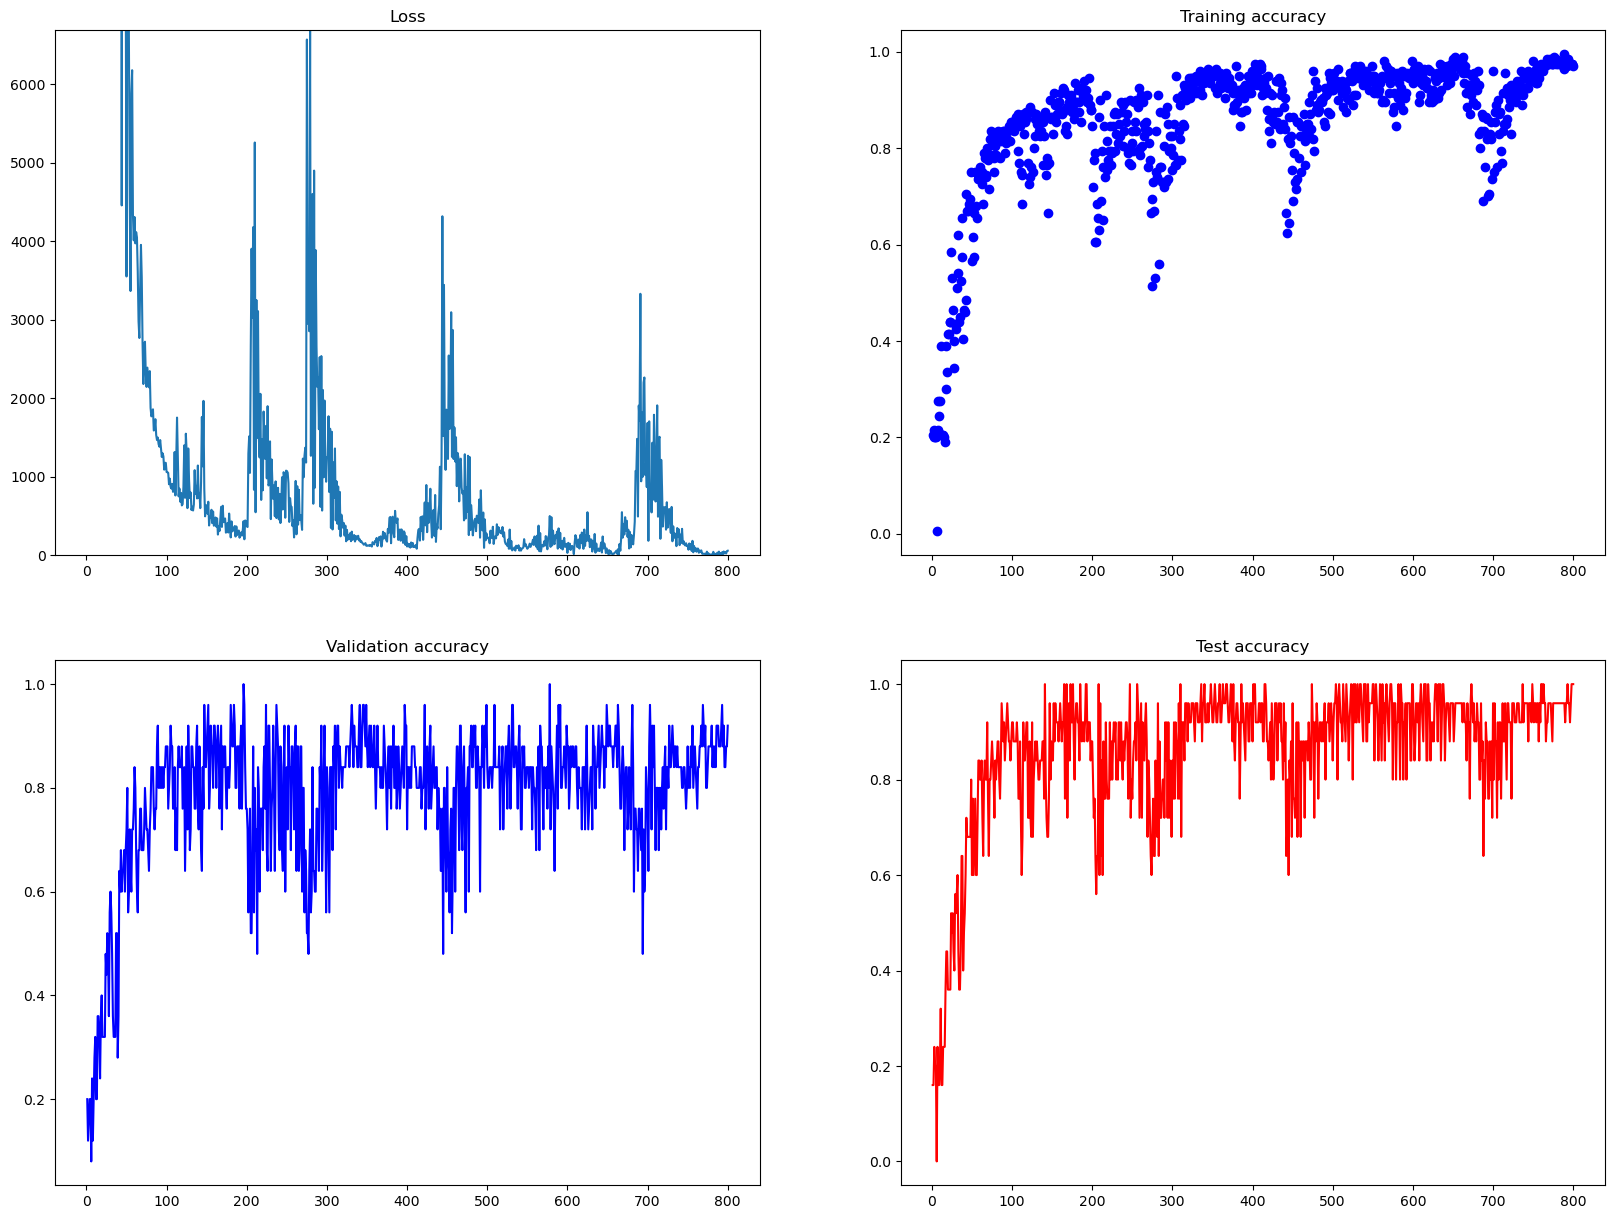

In [107]:
plot_4graphs(loss_list, acc_lists, 200, ".\slac\\figures\slac_5_sub.png")

In [108]:
mask = H_5['MIDI'].test_mask

predicted = model_5(H_5.x_dict, H_5.edge_index_dict)['MIDI'].argmax(dim=-1)[mask]

predicted

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4,
        4], device='cuda:0')

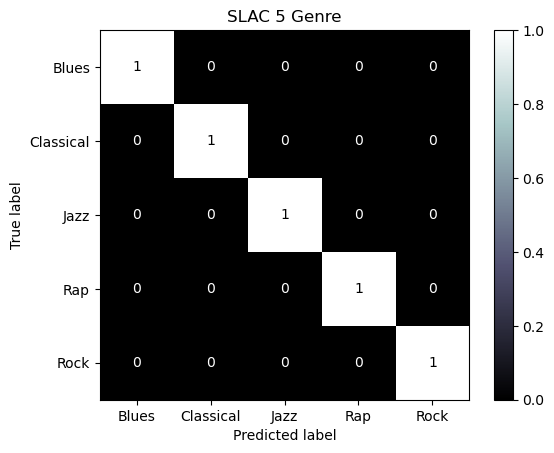

In [109]:
disp = ConfusionMatrixDisplay.from_predictions(y_true=lb.inverse_transform(H_5['MIDI'].y[mask].to('cpu')), y_pred=lb.inverse_transform(predicted.to('cpu')), cmap='bone', normalize='true')

disp.ax_.set_title('SLAC 5 Genre')
disp.figure_.savefig(".\slac\\figures\slac_5_conf_matrix.png")
plt.show()

## 10 class

In [56]:
nodes_df_complete.loc[nodes_df_complete['node_type'] == 'MIDI', ['name']]

,name
0,Blues_-_Modern-Albert_King_-_Born_Under_A_Bad_...
1029,Blues_-_Modern-B_B_King_-_How_Blue_Can_You_Get
2248,Blues_-_Modern-B_B_King_-_Rock_Me_Baby
2686,Blues_-_Modern-B_B_King_-_The_Thrill_Is_Gone
3738,Blues_-_Modern-Buddy_Guy_-_Don't_Answer_the_Door
...,...
92865,Rock_-_Metal-Rage_Against_the_Machine_-_Bulls_...
92925,Rock_-_Metal-Rage_Against_the_Machine_-_Gueril...
93030,Rock_-_Metal-Rage_Against_the_Machine_-_Killin...
93133,Rock_-_Metal-Rage_Against_the_Machine_-_Know_Y...


In [57]:
set([midi_type(s[0], 10) for s in midi_val])

{'Alternative',
 'Baroque',
 'Bop',
 'Hardcore_Rap',
 'Metal',
 'Modern',
 'Pop_Rap',
 'Romantic',
 'Swing',
 'Traditional'}

In [58]:
midi_class_10 = [midi_type(s[0], 10) for s in midi_val]

lb_10 = LabelEncoder()
y_10 = torch.from_numpy(lb_10.fit_transform(midi_class_10))  # .type(torch.LongTensor)

lb_10.classes_

array(['Alternative', 'Baroque', 'Bop', 'Hardcore_Rap', 'Metal', 'Modern',
       'Pop_Rap', 'Romantic', 'Swing', 'Traditional'], dtype='<U12')

In [59]:
input_node_dict_10 = input_node_dict.copy()

input_node_dict_10['MIDI']['y'] = y_10

In [60]:
H_10 = HeteroData(input_node_dict_10, **input_edge_dict).to(device)

In [61]:
print(H_10)

HeteroData(
  pitch={ x=[93, 1] },
  MIDI={
    x=[250, 1],
    y=[250]
  },
  tempo={ x=[23, 1] },
  time_sig={ x=[14, 1] },
  note_group={ x=[92484, 1] },
  velocity={ x=[11, 1] },
  duration={ x=[570, 1] },
  program={ x=[108, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] }
)


In [62]:
H_10 = T.ToUndirected()(H_10)

In [63]:
H_10 = T.RandomNodeSplit(num_val=0.1, num_test=0.1)(H_10)

In [64]:
print(H_10)

HeteroData(
  pitch={ x=[93, 1] },
  MIDI={
    x=[250, 1],
    y=[250],
    train_mask=[250],
    val_mask=[250],
    test_mask=[250]
  },
  tempo={ x=[23, 1] },
  time_sig={ x=[14, 1] },
  note_group={ x=[92484, 1] },
  velocity={ x=[11, 1] },
  duration={ x=[570, 1] },
  program={ x=[108, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] },
  (tempo, rev_has, MIDI)={ edge_index=[2, 250] },
  (time_sig, rev_in, MIDI)={ edge_index=[2, 239] },
  (program, rev_has, MIDI)={ edge_index=[2, 1392] },
  (note_group, rev_has, MIDI)={ edge_index=[2, 135160] },
  (velocity, rev_has, note_group)={ edge_index=[2, 118626] },
  (duration, rev_has, note_group)={ edge_index=[2, 924

In [65]:
model_10 = models.GraphSAGE(in_channels=-1, hidden_channels=64, num_layers=2, out_channels=len(set(lb_10.classes_)))
model_10 = to_hetero(model_10, H_10.metadata(), aggr='sum')
model_10.to(device)

GraphModule(
  (_trim): ModuleDict(
    (MIDI__has__tempo): TrimToLayer()
    (MIDI__in__time_sig): TrimToLayer()
    (MIDI__has__program): TrimToLayer()
    (MIDI__has__note_group): TrimToLayer()
    (note_group__has__velocity): TrimToLayer()
    (note_group__has__duration): TrimToLayer()
    (note_group__contains__pitch): TrimToLayer()
    (tempo__rev_has__MIDI): TrimToLayer()
    (time_sig__rev_in__MIDI): TrimToLayer()
    (program__rev_has__MIDI): TrimToLayer()
    (note_group__rev_has__MIDI): TrimToLayer()
    (velocity__rev_has__note_group): TrimToLayer()
    (duration__rev_has__note_group): TrimToLayer()
    (pitch__rev_contains__note_group): TrimToLayer()
  )
  (convs): ModuleList(
    (0): ModuleDict(
      (MIDI__has__tempo): SAGEConv(-1, 64, aggr=mean)
      (MIDI__in__time_sig): SAGEConv(-1, 64, aggr=mean)
      (MIDI__has__program): SAGEConv(-1, 64, aggr=mean)
      (MIDI__has__note_group): SAGEConv(-1, 64, aggr=mean)
      (note_group__has__velocity): SAGEConv(-1, 64, agg

In [66]:
optimizer_10 = torch.optim.Adam(model_10.parameters(), lr=0.01)

In [67]:
def train10():
    model_10.train()
    optimizer_10.zero_grad()
    out = model_10(H_10.x_dict, H_10.edge_index_dict)
    mask = H_10['MIDI'].train_mask
    loss = F.cross_entropy(out['MIDI'][mask], H_10['MIDI'].y[mask])
    loss.backward()
    optimizer_10.step()
    return float(loss)

In [68]:
@torch.no_grad()
def test10():
    model_10.eval()
    pred = model_10(H_10.x_dict, H_10.edge_index_dict)['MIDI'].argmax(dim=-1)

    accs = []
    for mask in [H_10['MIDI'].train_mask, H_10['MIDI'].val_mask, H_10['MIDI'].test_mask]:
        accs.append(int((pred[mask] == H_10['MIDI'].y[mask]).sum()) / int(mask.sum()))
    return accs

In [69]:
acc_lists = {'train': [], 'val': [], 'test': []}
loss_list = []
for epoch in range(1, 1601):
    loss = train10()
    train_acc, val_acc, test_acc = test10()

    loss_list.append(loss)

    acc_lists['train'].append(train_acc)
    acc_lists['val'].append(val_acc)
    acc_lists['test'].append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 372340.2812, Train: 0.1100, Val: 0.0000, Test: 0.1200
Epoch: 002, Loss: 208712.7812, Train: 0.0900, Val: 0.0800, Test: 0.0800
Epoch: 003, Loss: 267327.0938, Train: 0.1050, Val: 0.1200, Test: 0.0400
Epoch: 004, Loss: 333674.5938, Train: 0.1000, Val: 0.0800, Test: 0.1200
Epoch: 005, Loss: 451539.1250, Train: 0.1050, Val: 0.1200, Test: 0.0400
Epoch: 006, Loss: 564112.9375, Train: 0.0850, Val: 0.1600, Test: 0.1600
Epoch: 007, Loss: 626371.6250, Train: 0.1100, Val: 0.0400, Test: 0.0800
Epoch: 008, Loss: 768720.2500, Train: 0.1000, Val: 0.1600, Test: 0.0400
Epoch: 009, Loss: 830411.6875, Train: 0.0900, Val: 0.1600, Test: 0.1200
Epoch: 010, Loss: 852219.7500, Train: 0.0900, Val: 0.1600, Test: 0.1200
Epoch: 011, Loss: 778571.0625, Train: 0.1350, Val: 0.2400, Test: 0.0800
Epoch: 012, Loss: 668019.0625, Train: 0.1000, Val: 0.1600, Test: 0.0400
Epoch: 013, Loss: 576487.1250, Train: 0.1100, Val: 0.0400, Test: 0.0800
Epoch: 014, Loss: 540366.3750, Train: 0.1100, Val: 0.0400, Test:

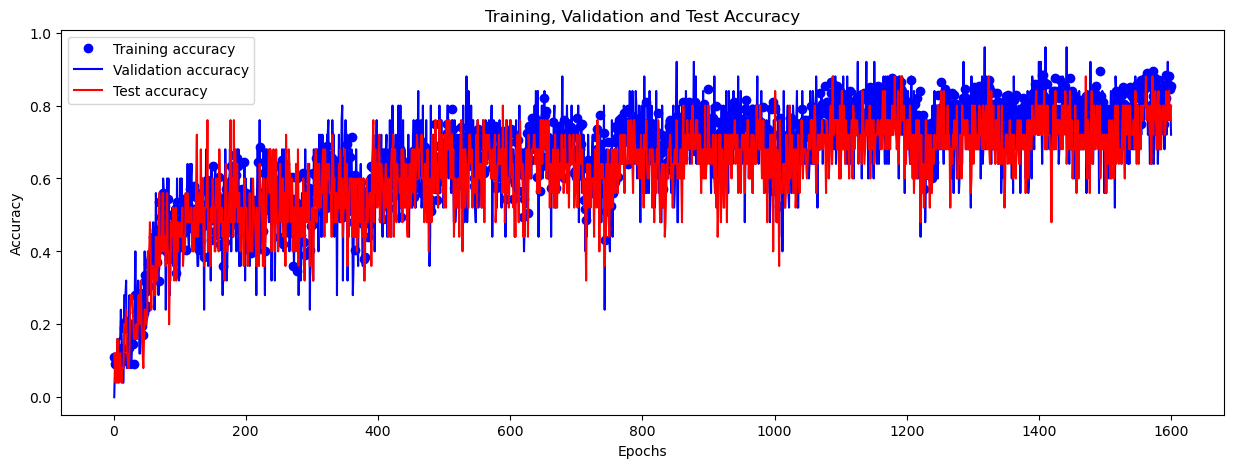

In [70]:
plot_graph(acc_lists, ".\slac\\figures\slac_10_tvt.png")

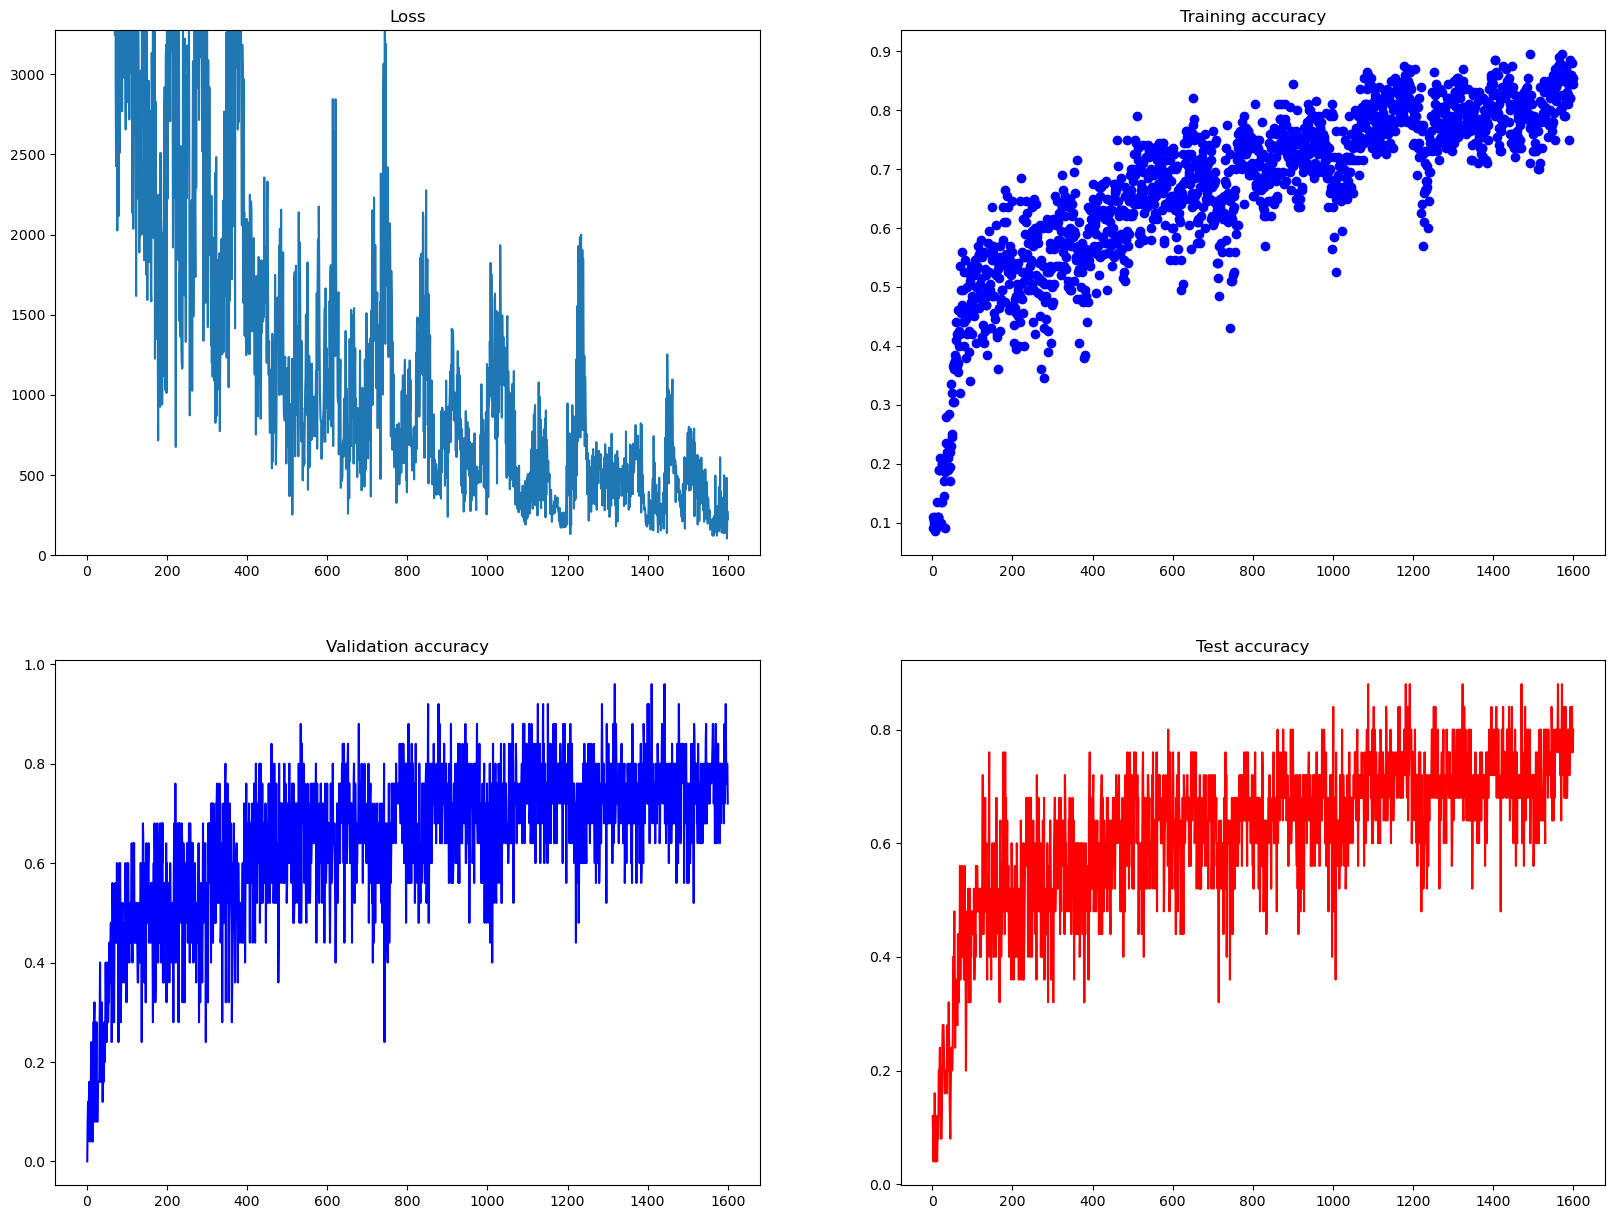

In [71]:
plot_4graphs(loss_list, acc_lists, 400, ".\slac\\figures\slac_10_sub.png")

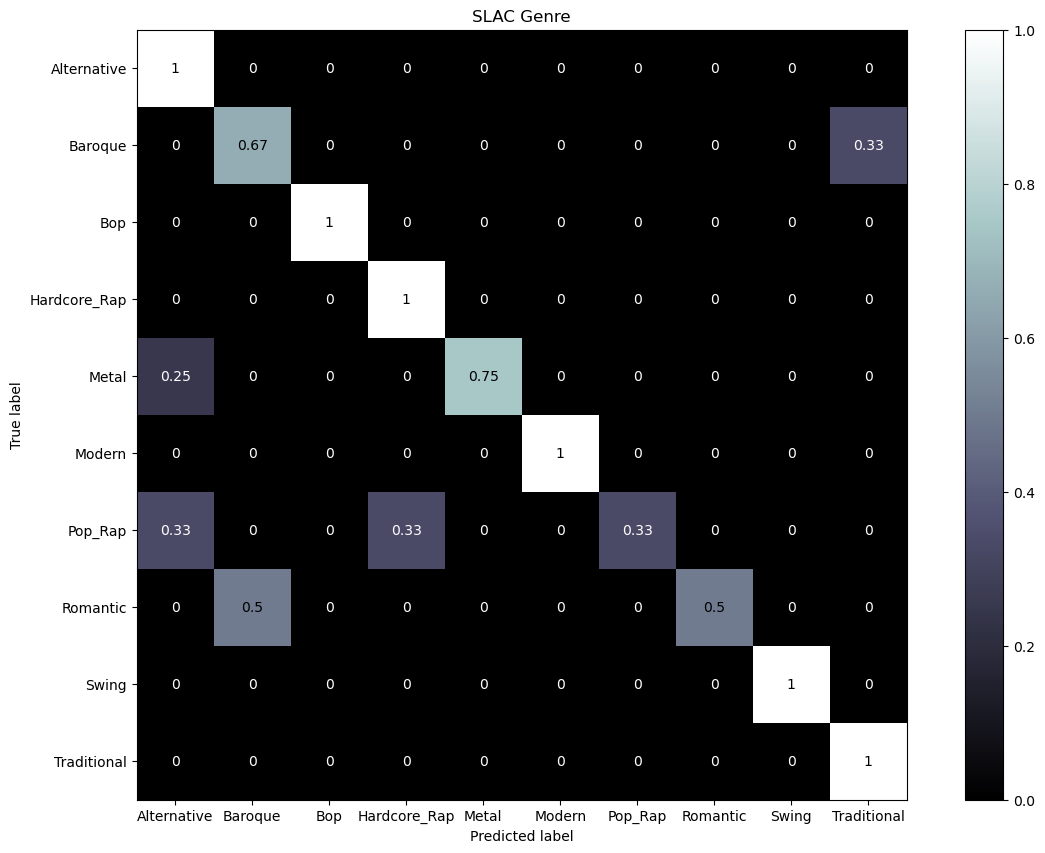

In [72]:
mask = H_10['MIDI'].test_mask

predicted = model_10(H_10.x_dict, H_10.edge_index_dict)['MIDI'].argmax(dim=-1)[mask]

predicted
disp = ConfusionMatrixDisplay.from_predictions(y_true=lb_10.inverse_transform(H_10['MIDI'].y[mask].to('cpu')),
                                               y_pred=lb_10.inverse_transform(predicted.to('cpu')), cmap='bone',
                                               normalize='true')

disp.ax_.set_title('SLAC Genre')
disp.figure_.set_size_inches(15, 10)
disp.figure_.savefig(".\slac\\figures\slac_10_conf_matrix.png")
plt.show()

In [73]:
winsound.Beep(400, 700)

 # Old Implementation

In [74]:
# nodes_ten_ = encoder.encode_nodes(nodes_df_complete)
# edges_ten_ = encoder.encode_edges(edges_df_complete)

# node_type_ = nodes_df_complete.iloc[:, 1]

# Get the source and target indices from the edges tensor
# edge_index = edges_ten_[:, :2]

## Get the edge types from the edges tensor
#edge_type_ = edges_df_complete.iloc[:, 2]

#full_hetero_graph = HeteroData(x=nodes_ten_, node_type=node_type_, edge_index=edge_index, edge_type=edge_type_)

In [75]:
# edges_df_complete.loc[edges_df_complete['edge_type'] == 'MIDI__has__tempo', ['source', 'target']]

In [76]:
# full_categories = node_categories.copy()
# full_categories['node_types'] = list(node_categories.keys())
# full_categories['edge_types'] = edge_types  # Dictionary containing every string that may be found in our Dataframes
# names_list_full = flatten_lol(full_categories.values())

In [77]:
# input_edge_dict = {edge_type: {'edge_index': encoder.encode_edges(edges_df_complete.loc[
#                    edges_df_complete['edge_type'] == edge_type, ['source', 'target']])} for edge_type in edge_types}
# for key in input_edge_dict.keys():
#     input_edge_dict[key]['edge_index'] = input_edge_dict[key]['edge_index'].T.to(torch.int64)
